In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline

### Download Data

This is a pre-crawled dataset, taken as subset of a bigger dataset (more than 7 million fashion products) that was created by extracting data from Amazon. It has details about various products, their manufacturer, description, price, customer reviews etc. This dataset has 10k data points to begin with.

In [2]:

reviews = pd.read_csv('https://query.data.world/s/jgeppofifbie3nkee44r2jiom5uboc')
print(reviews.shape)
num_rows = reviews.shape[0]

print(reviews)

#reviews.dtypes


(10000, 17)


uniq_id                                         object
product_name                                    object
manufacturer                                    object
price                                           object
number_available_in_stock                       object
number_of_reviews                               object
number_of_answered_questions                   float64
average_review_rating                           object
amazon_category_and_sub_category                object
customers_who_bought_this_item_also_bought      object
description                                     object
product_information                             object
product_description                             object
items_customers_buy_after_viewing_this_item     object
customer_questions_and_answers                  object
customer_reviews                                object
sellers                                         object
dtype: object

## Data Cleaning

- Remove columns that have more than 30% Nan values.
- Remove rows that have Nan values for: `number_of_reviews, price price & average_review_rating`
- Fill with 0's where `number_available_in_stock` is Nan
- Convert customer rating to a float


In [3]:
nan_cols = (reviews.isnull().sum() > 0.3*num_rows)
for idx, val in nan_cols.items():
  if (val==True):
    reviews.drop(columns=idx, inplace=True)

# should have dropped 3 columns -> 14
print(reviews.shape)
print(reviews.columns)

important_columns = ['number_of_reviews', 'number_available_in_stock', 'price','average_review_rating']
reviews.dropna(subset=['number_of_reviews', 'price','average_review_rating'], inplace=True)

# Down to (8550, 14)
print(reviews.shape)


# Fill with 0's where number_available_in_stock is Nan
print(reviews['number_available_in_stock'].isnull().sum())
reviews.fillna({"number_available_in_stock": 0}, inplace=True)
print(reviews['number_available_in_stock'].isnull().sum())

reviews['average_review_rating'] = reviews['average_review_rating'].replace(' out of 5 stars','', regex=True).astype(float)


(10000, 14)
Index(['uniq_id', 'product_name', 'manufacturer', 'price',
       'number_available_in_stock', 'number_of_reviews',
       'number_of_answered_questions', 'average_review_rating',
       'amazon_category_and_sub_category',
       'customers_who_bought_this_item_also_bought', 'description',
       'product_information', 'product_description', 'customer_reviews'],
      dtype='object')
(8550, 14)
2228
0




--- Tier 1 ---


Average rating over all products: 4.709602339181297
Maximum number of answered questions for a given product: 39.0
Details of the product with the longest written name are as follows:
 uniq_id                                                        3b2a77eafbbbdc7536eab7637c0c79a4
product_name                                     Plush Soft Toy White Lamb by Hansa. 18cm. 4562
manufacturer                                                                              Hansa
price                                                                                    £14.99
number_available_in_stock                                                                11 new
number_of_reviews                                                                             2
number_of_answered_questions                                                                  1
average_review_rating                                                                         5
amazon_category_and_sub_cate

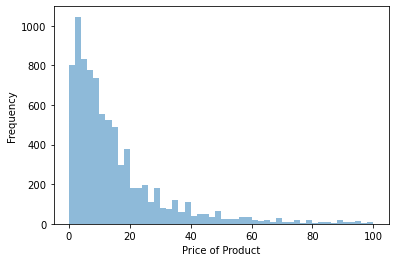

<Figure size 432x288 with 0 Axes>

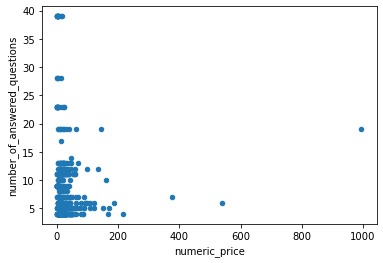

<Figure size 432x288 with 0 Axes>

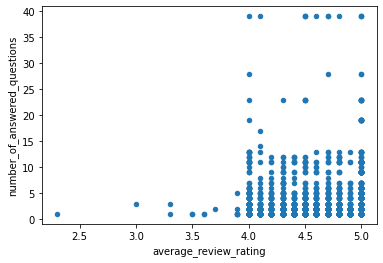

In [11]:
## Tier 1 analyses: 3
print("\n\n--- Tier 1 ---\n\n")

# What is the average of the averge rating of products in these reviews?
print(f"Average rating over all products: {reviews['average_review_rating'].mean()}")

# What is the maximum number ofanswered questions for a prouct?
print(f"Maximum number of answered questions for a given product: {reviews['number_of_answered_questions'].max()}")

# What are the details of product with the longest product name?
print(f"Details of the product with the longest written name are as follows:\n {reviews.loc[reviews['product_name'].str.len().max()]}")

## Tier 2 analyses: 2
print("\n\n--- Tier 2 ---\n\n")

# What are the 10 manufactures that have the lowest average product ratings
lowest_ranked = reviews.groupby("manufacturer")["average_review_rating"].mean().sort_values()
print(f"10 manufactures with the lowest average rating:\n{lowest_ranked.head(10)}")

# What are the manufacturers with over 90 products listed in this dataset 
products = reviews.groupby("manufacturer")["product_name"].count().sort_values(ascending=False)
for i, v in products.items():
  if v < 90:
    break
  print(f"Manufacturer: {i} with {v} number of products")

## Tier 3 analyses: 1
print("\n\n--- Tier 3 ---\n\n")

# Here we will try to find the product names for the 20 most expensive products that are listed  in this

# There are certain products that have a range of price listed (along with pound currency symbol) than a numeric value.
# For these we will take the average of the range as the price for out analysis.
print(f"Products that specify a price range:\n{reviews.loc[lambda df : df['price'].str.contains('-'), ['product_name', 'price']]}")

# We will use the following regex to extract the integer and floating point numbers and then average over them if they return a list. 
# The list will have atmost 2 numbers since the column contains a range.
[float(s) for s in re.findall(r'\b(\d+\.\d+|\d+)\b', 'he33llo 42.75 I\'m a 32.23838 string 30')]

def numeric_price(price):
  num_p = [float(s) for s in re.findall(r'\b(\d+\.\d+|\d+)\b', price)]
  return sum(num_p)/len(num_p)


reviews['numeric_price'] = reviews['price'].apply(numeric_price)

#ax = reviews['numeric_price'].plot.hist(bins=100, alpha=0.5)

print(reviews['numeric_price'].min())
print(reviews['numeric_price'].max())
print((reviews['numeric_price'] > 100).sum())

# Next we visualize in a histogram the frequency of products listed that are under $100. This gives us an idea of the price distribution of the relatively cheaper
# products
ax2 = reviews.loc[reviews['numeric_price'] <= 100, 'numeric_price'].plot.hist(bins=50, alpha=0.5)
plt.xlabel("Price of Product")
plt.figure()

# For the next bit of our analysis lets do a scatter plot between the number of questions asked for a product and its corresponding price. 
# This can potentially tell us if customers ask more questions for expensive products? To make the plot less cluttered we only consider data points where 
# more than 3 questions were asked.
more_than_n_questions = reviews.loc[lambda df : df['number_of_answered_questions'] > 3]
more_than_n_questions.plot.scatter(x='numeric_price', y='number_of_answered_questions')
